# MatSE 410 unary pycalphad examples




**pycalphad** is a free and open source software written in Python for performing thermodynamic calculations within the CALculation of PHAse Diagrams (CALPHAD) method.


This guide was contributed to by

- Shuang Lin (2024)
- Brandon Bocklund (2019, 2020)
- Matthew Feurer (2019)



## Introduction to pycalphad

This tutorial is being run from the Jupyter Lab program in the browser. You can run Jupyter Lab by running `jupyter lab` in the Anaconda Prompt.

In Python you need to import the tools that we use to preform our code. They act as additions to the basic Python language. In general you can copy them as you see here without any modification. At the begining of any new session you must run these import statements to get all the tools we need. if the command below exicutes without any errors, your installation of pycalphad is succesfull.


### Databases

Any calculation in pycalphad requires you to define:

* A Database
* The components to consider
* The phases to consider
* The conditions of the calculation

CALPHAD database files are made by researchers who model the Gibbs energy functions. The parameters (Gibbs energy functions) in the databases are stored in the Thermo-Calc DataBase (TDB) format. Files are usually saved with the file extension `.tdb`. These files are read by pycalphad by importing the `Database` class and running the following

```python
from pycalphad import Database
db = Database("path/to/database.tdb")
```

Many database files have been indexed at the [TDBDB](https://avdwgroup.engin.brown.edu), which can be used to search for TDB files. Many binary and ternary systems have been evaluated, some more than once as new data or calculations are published.

Some databases are included here (`Zn-ssub5.tdb`) and (`sgte-unary.tdb`), which contain parameters for Zn solid/liquid/gas and parameters for many pure elements in the liquid and various solid phases (e.g. fcc, bcc, hcp; even if that phase is not stable), respectively.


## One component systems

Here we first import some functions that will be used in these examples, then load the SGTE unary TDB and calculate some properties of Al vs. temperature.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pycalphad import Database, calculate, equilibrium, variables as v
from PT import PT_phase_diagram

In [2]:
# Load the database
db_sgte = Database('sgte-unary.tdb')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pycalphad/io/tdb.py:974: UserWarning: The type definition character `I` was defined in the following phases: ['CBCC_A12', 'BCC_A2', 'FCC_A1', 'HCP_A3'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


The SGTE database has many elements and phases, which can be listed.

#### Elements

Note there are two special "elements": `/-` and `VA`. `/-` is used in databases to represent a unit of negative charge, while `VA` is a dummy species that means vacancy.

**Note that many databases require `VA` are included in the sublattice models, so you should get in the habit of included them in the lists of components manually**

In [3]:
print(sorted(db_sgte.elements))

['/-', 'AG', 'AL', 'AM', 'AS', 'AU', 'B', 'BA', 'BE', 'BI', 'C', 'CA', 'CD', 'CE', 'CO', 'CR', 'CS', 'CU', 'DY', 'ER', 'EU', 'FE', 'GA', 'GD', 'GE', 'HF', 'HG', 'HO', 'IN', 'IR', 'K', 'LA', 'LI', 'LU', 'MG', 'MN', 'MO', 'N', 'NA', 'NB', 'ND', 'NI', 'NP', 'O', 'OS', 'P', 'PA', 'PB', 'PD', 'PR', 'PT', 'PU', 'RB', 'RE', 'RH', 'RU', 'S', 'SB', 'SC', 'SE', 'SI', 'SM', 'SN', 'SR', 'TA', 'TB', 'TC', 'TE', 'TH', 'TI', 'TL', 'TM', 'U', 'V', 'VA', 'W', 'Y', 'YB', 'ZN', 'ZR']


#### Phases

Many of the phases you know have some symbols after the underscore in the phase name, for example `FCC_A1` has `A1`. These are called *Strukturbericht* symbols. The letter sometimes has meaning (e.g. `A` for pure elements), but the number has almost no meaning and usually the numbers roughly correspond to the order in which they were discovered/named.

For CALPHAD calculations, it's just a convention.

A list of many phases and Strukturbericht symbols can be found [here](https://homepage.univie.ac.at/michael.leitner/lattice/struk/index.html).

In [4]:
print(sorted(db_sgte.phases))

['ALPHA_PU', 'ALPHA_RHOMBO_B', 'BCC_A2', 'BCT_A5', 'BCT_AA', 'BETA_PU', 'BETA_RHOMBO_B', 'CBCC_A12', 'CUB_A13', 'DHCP', 'DIAMOND_A4', 'FCC_A1', 'GAMMA_PU', 'GAS', 'GRAPHITE', 'HCP_A3', 'HCP_ZN', 'HEXAGONAL_A8', 'LIQUID', 'MONOCLINIC', 'OMEGA', 'ORTHORHOMBIC_A20', 'ORTHORHOMBIC_GA', 'ORTHORHOMBIC_S', 'ORTHO_AC', 'RED_P', 'RHOMBOHEDRAL_A7', 'RHOMBO_A10', 'RHOMB_C19', 'TETRAGONAL_A6', 'TETRAGONAL_U', 'TETRAG_AD', 'TET_ALPHA1', 'WHITE_P']


### `calculate()` and `equilibrium()`

The main two functions for computing things with pycalphad are `calculate()` and `equilibrium()`. There is a subtle difference between these that may not be very clear initially.

* `calculate()` computes a property of a phase for given natural variables for Gibbs energy ($P$, $T$, and $N$)
* `equilibrium()` finds the phases and phase fractions that give the global minimum Gibbs energy constrained under conditions of $P$, $T$, and $x_i$. It uses pycalphad to numerically sample the Gibbs energies of phases that could form under the given conditions.

Whenever we want to see a property of a phase, regardless of whether or not it's stable, we use `calculate()`.

Whenever we want to know the experimental/equilibrium properties, i.e. which phases are stable, we use `equilibrium()`.

The inputs of each are slightly different, in that `calculate()` takes state variables as keyword arguments, while `equilibrium()` takes the conditions as a dictionary. If you don't know what this means, the examples will help clarify.

### State variables

In any thermodynamic calculation, $c+2$ conditions must be defined for $c$ independent components. Note that `VA` is not an independent component.

The different state variables are accessed by prepending `v.<StateVariable>`:

- **Pressure:** `v.P` in Pascal. Standard pressure is 101325 Pa.
- **Moles:** `v.N` only use `N=1`.
- **Temperature:** `v.T` in Kelvin. Most databases are only defined between 298.15 K and 6000 K, so you should keep calculations in this range.
- **Composition:** `v.X('NI')` as a mole fraction (for Ni).


### Gibbs energy of Al

First, calculate the Gibbs energy of Al for all phases over all temperatures. Since we want to see the energies for phases even if they are not stable, we'll use `calculate()`. 

Ranges of state variables can be defined using a `(start, stop, step)` format, e.g. `T=(300, 1500, 10)` goes from 300 K to 1500 K by intervals of 10 K.

**Remember to include `VA` as a component, since it is used by the FCC_A1 phase.**

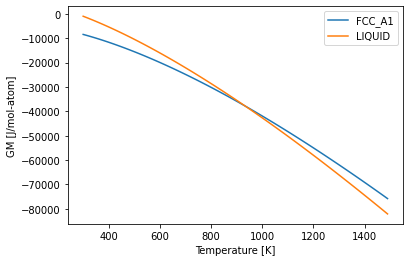

In [5]:
fcc_GM = calculate(db_sgte, ['AL', 'VA'], 'FCC_A1', P=101325, T=(300, 1500, 10), N=1)
liquid_GM = calculate(db_sgte, ['AL', 'VA'], 'LIQUID', P=101325, T=(300, 1500, 10), N=1)

# Squeeze is required because the array corresponding to GM is multidimensional for each T, P, and N where we've calculated the energy
plt.plot(fcc_GM.T, fcc_GM.GM.squeeze(), label='FCC_A1')
plt.plot(liquid_GM.T, liquid_GM.GM.squeeze(), label='LIQUID')
plt.xlabel("Temperature [K]")
plt.ylabel("GM [J/mol-atom]")
plt.legend()


### Equilibrium enthalpy of Zn

Now we want to see the enthalpy change as a function of temperature, and see that the enthalpy is discontinuous at the two phase equilibrium transformation temperature, according to Gibbs phase rule.

To be able to see the enthalpy, we have to provide an `output` argument to equilibrium to ask for the `HM` (molar enthalpy). The list of quantities you can ask for are:

```
Molar enthalpy (HM)       'HM'
Mixing enthalpy           'HM_MIX'
Molar Gibbs energy        'GM'
Gibbs energy of mixing    'GM_MIX'
Molar Entropy             'SM'
Molar Heat capacity       'CPM'
```

For now, only consider the solid and liquid phases.
    

In [6]:
db_zn = Database('Zn-ssub5.tdb')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pycalphad/io/tdb.py:974: UserWarning: The type definition character `%` was defined in the following phases: ['GAS', 'SOLID', 'LIQUID'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


In [7]:
print(sorted(db_zn.phases))

['GAS', 'LIQUID', 'SOLID']


Text(0, 0.5, 'HM [J/mol-atom]')

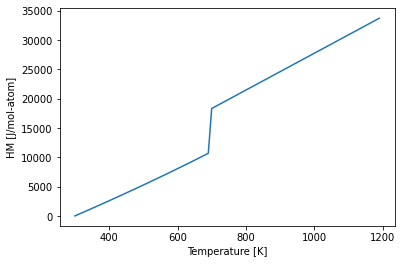

In [8]:
conditions = {  # mapping of state variable to values
    v.N: 1,
    v.P: 101325,
    # for now, only temperature has a range. If multiple variables have ranges, all combinations are calculated
    v.T: (300, 1200, 10),
}
equil_result = equilibrium(db_zn, ['ZN'], ['SOLID', 'LIQUID'], conditions, output='HM')

# Squeeze is required because the array corresponding to HM is multidimensional for each T, P, and N where we've calculated the energy
plt.plot(equil_result.T, equil_result.HM.squeeze())
plt.xlabel("Temperature [K]")
plt.ylabel("HM [J/mol-atom]")

## Pressure Temperature phase diagram

The `PT_phase_diagram` function is written for you to use `calculate()` to determine the PT diagram. here's one for ZN:

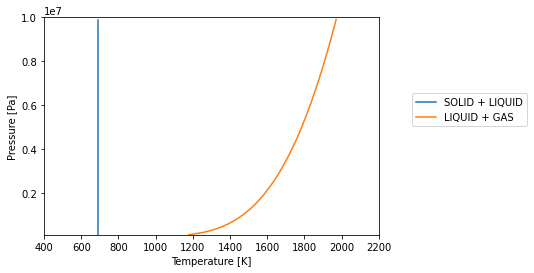

In [9]:
PT_phase_diagram(db_zn, ['ZN'], ['GAS', 'SOLID', 'LIQUID'], {v.N: 1, v.P: (1e5, 1e7, 1e5), v.T: (400, 2200, 1)})